# NOT ENDED
# Loading modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from irls.irls import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
SEED = 123

# Dataset - Breast Cancer

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [3]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
y.value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

# Evaluation of models

In [5]:
pipe = Pipeline([
    ("transformer", StandardScaler()),
    ("knn", KNeighborsClassifier())
]
)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
result = []
for name, model in [("QDA", QDA()), ("LDA", LDA()), ("Logistic Regression", LogisticRegression()),
                    ("KNN", pipe)]:
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X, y)):
        X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
        X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]
        fitted_model = clone(model).fit(X_train, y_train)
        y_proba = fitted_model.predict_proba(X_test)[:, 1] if name != "Logistic Regression" else fitted_model.predict_proba(X_test)
        y_pred = fitted_model.predict(X_test)
        res = {
            "model": name,
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced accuracy": balanced_accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "roc auc": roc_auc_score(y_test, y_proba)
        }
        result.append(res)

result_df = pd.DataFrame(result)
result_df

,model,accuracy,balanced accuracy,F1,roc auc
0,QDA,0.929825,0.925974,0.942857,0.989610
1,QDA,0.912281,0.903247,0.929577,0.984416
2,QDA,0.947368,0.938492,0.958904,0.980159
3,QDA,0.964912,0.952381,0.972973,0.996032
4,QDA,0.947368,0.948413,0.957746,0.992063
5,QDA,0.982456,0.986111,0.985915,1.000000
6,QDA,0.982456,0.976190,0.986301,0.993386
7,QDA,1.000000,1.000000,1.000000,1.000000
8,QDA,0.929825,0.934524,0.942857,0.986772
9,QDA,0.964286,0.971429,0.970588,0.994558


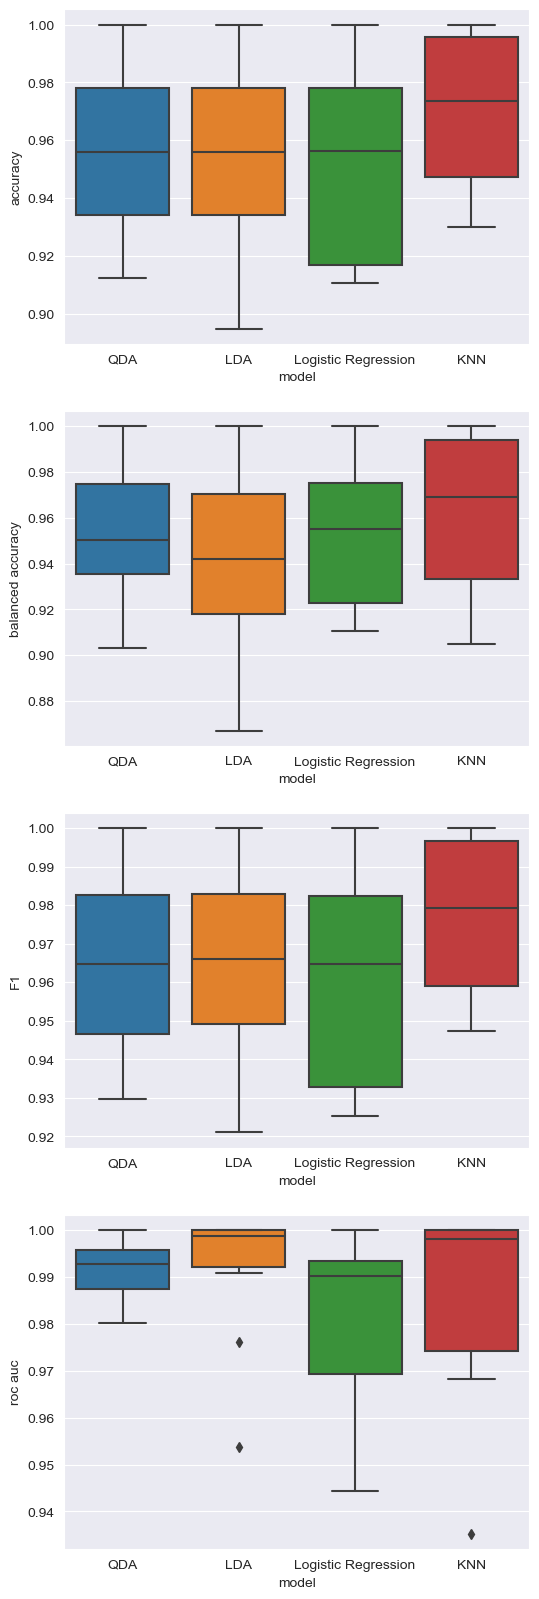

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(6, 20))
sns.boxplot(result_df, x="model", y="accuracy", ax=axes[0])
sns.boxplot(result_df, x="model", y="balanced accuracy", ax=axes[1])
sns.boxplot(result_df, x="model", y="F1", ax=axes[2])
sns.boxplot(result_df, x="model", y="roc auc", ax=axes[3])
plt.show()